### Data Analysis Pipeline

- **Create Simulation**: Represent Ancient and moderate selection.
- **Leverage Pre-trained Model**: Use the hyperpamaters from bayesian optimisation
- **Training Regimen**:
  - Train for 10 epochs.
  - 10 epochs each from batches 1-9 of training data.
  - Test on the final batch of unseen data.
- **40k Simulations used**




In [1]:
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Navigate to the cloned repository
%cd EvoNet-CNN-Insight/model_training/Ancient_moderate

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 6197, done.
remote: Counting objects: 100% (1818/1818), done.
remote: Compressing objects: 100% (1099/1099), done.
remote: Total 6197 (delta 803), reused 1673 (delta 701), pack-reused 4379 (from 1)
Receiving objects: 100% (6197/6197), 8.08 GiB | 17.27 MiB/s, done.
Resolving deltas: 100% (2394/2394), done.
Updating files: 100% (231/231), done.
/content/EvoNet-CNN-Insight/model_training/Ancient_moderate


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")


# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Run ImaGene.py

In [3]:
%run -i ../../ImaGene.py

In [ ]:
#run to make simulations
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_ancient_moderate.txt".split());

 the first iteration of training.


In [4]:

path_sim = './'

In [5]:
file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [6]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000);

We can have a look at the data stored in this object.

In [7]:
gene_sim.summary();

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 178, max 482, mean 320.644250, std 46.220214


In [8]:
# Filter simulations based on frequency threshold of 0.01
gene_sim.filter_freq(0.01)

# Sort simulations by row frequency
gene_sim.sort('rows_freq')

# Provide summary of the simulation data
gene_sim.summary()
# Resize simulation data to (198, 192)
gene_sim.resize((198, 192))

# Provide summary of the simulation data
gene_sim.summary()
# Convert simulation data with data augmentation (flip)
gene_sim.convert(flip=True)

# Provide summary of the simulation data
gene_sim.summary()


An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 106, max 394, mean 233.239500, std 44.035510
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

information on the corresponding targets (in this case the selection coefficient, either 0 or selection coefficient of choice in $2N_e$ units with $N_e = 10000$).

0


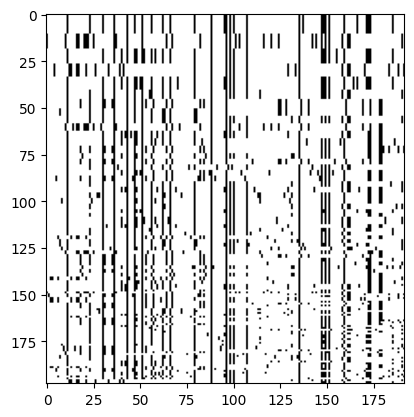

200


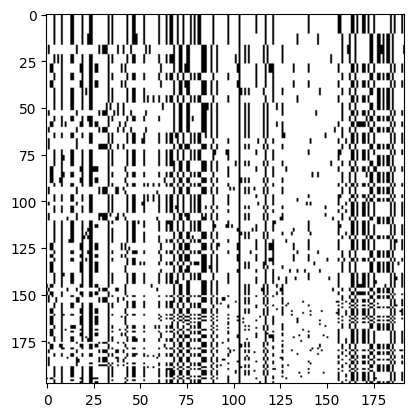

In [9]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [12]:
# Subset the simulation data with random indices
gene_sim.subset(get_index_random(gene_sim))

# Convert targets to binary format
gene_sim.targets = to_binary(gene_sim.targets)


Use Hyperparameters from the Bayesian Optimisation script

In [13]:


def build_best_model(input_shape):
    # Best hyperparameters from the new Optuna optimization
    num_layers = 5  # Number of layers
    filters = [65, 128, 77, 48, 127]  # Filters for each convolutional layer
    kernel_size = 2  # Kernel size
    l1 = 5.39171365329603e-06  # L1 regularization
    l2 = 0.000508098182990793  # L2 regularization
    dense_units = 122  # Units in the dense layer
    dropout_rate = 0.44775481260866545  # Dropout rate
    learning_rate = 0.00023021217142648836  # Learning rate

    # Building the model based on the provided hyperparameters
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  # Define the input layer
    for i in range(num_layers):
        model.add(layers.Conv2D(filters=filters[i], kernel_size=(kernel_size, kernel_size), strides=(1, 1), activation='relu',
                                kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), padding='same'))  # 'same' padding to preserve dimensions
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())  # Flatten the output for the Dense layers
    model.add(layers.Dense(units=dense_units, activation='relu'))  # Dense layer
    model.add(layers.Dropout(rate=dropout_rate))  # Dropout layer
    model.add(layers.Dense(units=1, activation='sigmoid'))  # Output layer with sigmoid activation

    optimizer = optimizers.Adam(learning_rate=learning_rate)  # Define optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Compile the model

    return model

# Assuming gene_sim.data is already preprocessed
input_shape = gene_sim.data.shape[1:]

# Build the model
model = build_best_model(input_shape)

# Print the model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 198, 192, 65)        │             325 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 99, 96, 65)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 99, 96, 128)         │          33,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 49, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 49, 48, 77)          │          39,501 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 24, 24, 77)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 48)          │          14,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 127)         │          24,511 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 127)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4572)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 122)                 │         557,906 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 122)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             123 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 670,606 (2.56 MB)

 Trainable params: 670,606 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=10, verbose=1, validation_split=0.20)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.4955 - loss: 0.8723 - val_accuracy: 0.4900 - val_loss: 0.8479
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.4868 - loss: 0.8415 - val_accuracy: 0.4900 - val_loss: 0.8197
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.4925 - loss: 0.8140 - val_accuracy: 0.4900 - val_loss: 0.7992
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.4883 - loss: 0.7957 - val_accuracy: 0.4900 - val_loss: 0.7815
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5004 - loss: 0.7775 - val_accuracy: 0.4900 - val_loss: 0.7877
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5280 - loss: 0.7661 - val_accuracy: 0.4900 - val_loss: 0.7578
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5162 - loss: 0.7552 - val_accuracy: 0.4900 - val_loss: 0.7513
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5718 - loss: 0.7266 - val_accuracy: 0.6687 -

In [15]:
net_LCT = ImaNet(name='Bayesian_opt_ARC')


In [16]:
net_LCT.update_scores(score);

In [17]:

i = 2
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

i = 2
while i < 10:

    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=10, verbose=1, validation_split=0.20)

    # Append scores to all_scores dictionary
    all_scores['loss'].extend(score.history['loss'])
    all_scores['val_loss'].extend(score.history['val_loss'])
    all_scores['accuracy'].extend(score.history['accuracy'])
    all_scores['val_accuracy'].extend(score.history['val_accuracy'])

    i += 1


2
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6568 - loss: 0.6290 - val_accuracy: 0.6662 - val_loss: 0.6411
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6708 - loss: 0.6248 - val_accuracy: 0.6800 - val_loss: 0.6186
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.6956 - loss: 0.6016 - val_accuracy: 0.6812 - val_loss: 0.6259
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.6926 - loss: 0.5942 - val_accuracy: 0.7387 - val_loss: 0.5694
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.7236 - loss: 0.5703 - val_accuracy: 0.7412 - val_loss: 0.5546
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7263 - loss: 0.5586 - val_accuracy: 0.7575 - val_loss: 0.5522
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7523 - loss: 0.5468 - val_accuracy: 0.7375 - val_loss: 0.5623
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7525 - loss: 0.5478 - val_accuracy: 0.7462 -

Better Plotting visualisation

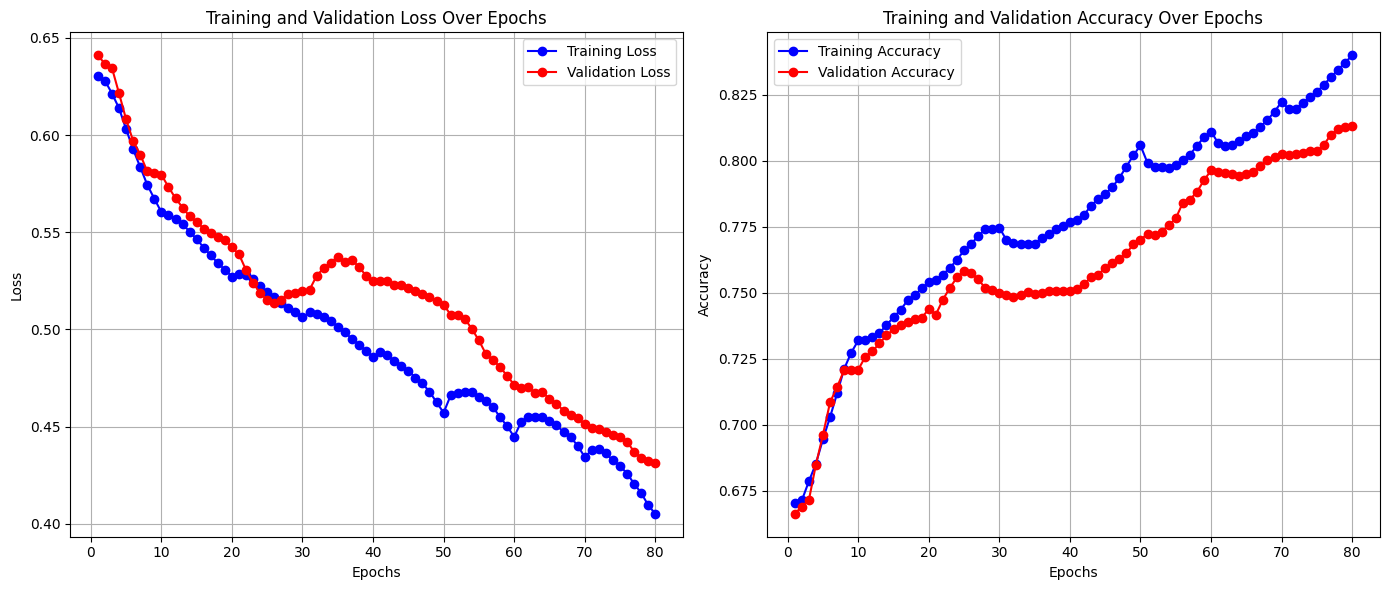

In [18]:
# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Function to smooth the data for better visualization (optional)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Create a figure for plotting with better visualization settings
plt.figure(figsize=(14, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_curve(all_scores['loss']), 'bo-', label='Training Loss')
plt.plot(epochs, smooth_curve(all_scores['val_loss']), 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_curve(all_scores['accuracy']), 'bo-', label='Training Accuracy')
plt.plot(epochs, smooth_curve(all_scores['val_accuracy']), 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()



Evaluate the training on the testing dataset, Which is the last batch of the the 10th simulation in the file
The log the testing validation and loss alongside the F1,

In [19]:
# Set the simulation index
i = 10

# Create an ImaFile object for the specified simulation folder and model
file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the simulation data with the specified parameter and maximum number of replicates
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

# Filter the simulations based on a frequency threshold of 0.01
gene_sim_test.filter_freq(0.01)

# Sort the simulations by row frequency
gene_sim_test.sort('rows_freq')

# Resize the simulation data to the specified dimensions (198, 192)
gene_sim_test.resize((198, 192))

# Convert the simulation data with data augmentation (flip=True)
gene_sim_test.convert(flip=True)

# Get a random subset of indices and subset the simulation data
rnd_idx = get_index_random(gene_sim_test)  # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

# Convert the targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)


In [20]:

net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]


[0.43830999732017517, 0.8224999904632568]


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


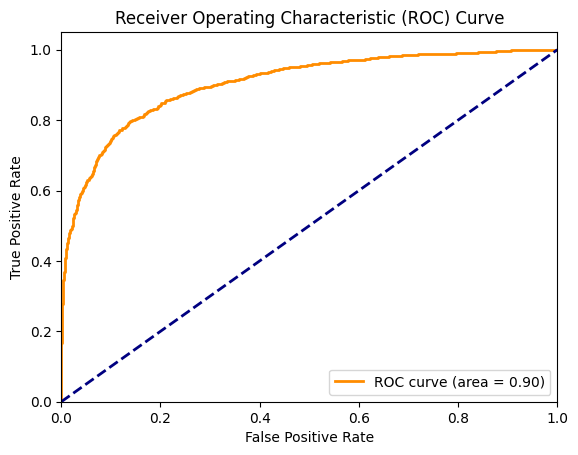

F1 Score: 0.8077964266377909
Precision: 0.8807556080283353
Recall (Sensitivity): 0.746


In [21]:
# Make predictions on the validation data
predictions = model.predict(gene_sim_test.data)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, predictions.round())

# Calculate precision, recall, and F-score
precision, recall, fscore, _ = precision_recall_fscore_support(gene_sim_test.targets, predictions.round(), average='binary')

# Recall is equivalent to sensitivity
sensitivity = recall

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print additional metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {sensitivity}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


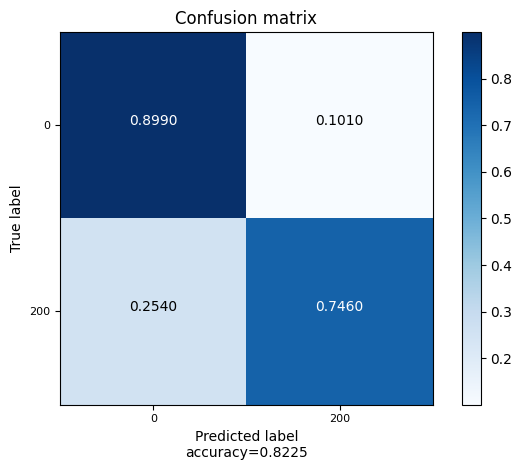

0

In [22]:
# Make predictions on the test data using the trained model and store the results in net_LCT
net_LCT.predict(gene_sim_test, model)

# Plot the confusion matrix of the predictions against the true classes, with text labels for clarity
net_LCT.plot_cm(gene_sim_test.classes, text=True)


In [23]:
path = './'
filename = 'AM_Bayes_opt.keras'

# Save the trained model to a file using the recommended Keras format
model.save(path + filename)
#Model saved to Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path and filename
path = '/content/drive/My Drive/models/'
filename = 'AM_Bayes_opt.keras'

# Save the trained model to the specified path
model.save(path + filename)